# 모델링

- 파생변수 목록
    - TenureByAge
    - Engagement
    - CreditScoreByBalance
    - BalanceByAge
    - NumOfProductsByBalance
    - age_group
    - Balance_group

- 최종 모델
    - Soft Voting
        - GBC, LightGBM, XGBoost : 0.8920

## 패키지 설치 및 로드

In [ ]:
!pip install -q joblib==1.3
!pip install -q pycaret
!pip install -q catboost
!pip install --upgrade -q xgboost
!pip install bayesian-optimization==1.4.2

In [ ]:
# 기본 패키지
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 전처리 (원핫은 pd.dummies로 이용)
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

# 데이터 분리
from sklearn.model_selection import train_test_split, GridSearchCV

# 모델 선택 도움, 하이퍼 파라미터
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from bayes_opt import BayesianOptimization

# catboost
import pycaret
from pycaret.classification import *
import catboost
from catboost import CatBoostClassifier

# LightGBM
from lightgbm import LGBMClassifier
# 앙상블
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,VotingClassifier

#xgboost
import xgboost as xgb
from xgboost import XGBClassifier

# 모델 평가, 점수
from sklearn.metrics import roc_auc_score, roc_curve

# 변수 중요도
from sklearn.inspection import permutation_importance

## 전처리

In [ ]:
# 데이터 로드
train = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/train.csv')
test = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/테크잇 /9. 파이널 프로젝트 - 12/bank/sample_submission.csv')

# 변수 제거 : id, CustomerId, Surname
columns_to_drop = ['id', 'CustomerId', 'Surname']
train.drop(columns=columns_to_drop, inplace=True)
test.drop(columns=columns_to_drop, inplace=True)

# 중복 제거(전체 중복)
train = train.drop_duplicates()

# 타입 변경
## float -> int
train[['HasCrCard','IsActiveMember']] = train[['HasCrCard','IsActiveMember']].astype(int)
test[['HasCrCard','IsActiveMember']] = test[['HasCrCard','IsActiveMember']].astype(int)

## Encoding(Object -> int)
train = pd.get_dummies(train, columns=['Geography', 'Gender'],dtype=int)
test = pd.get_dummies(test, columns=['Geography', 'Gender'],dtype=int)

## float -> int(소수점 제거)
train['Age'] = (train['Age'] *10).astype(int)
train['Balance'] = round(train['Balance']).astype(int)
train['EstimatedSalary'] = (train['EstimatedSalary']*100).astype(int)

test['Age'] = (test['Age'] *10).astype(int)
test['Balance'] = round(test['Balance']).astype(int)
test['EstimatedSalary'] = (test['EstimatedSalary']*100).astype(int)

# 파생변수 생성

## 연령 별 은행사용기간
train['TenureByAge'] = train.groupby('Age')['Tenure'].transform('mean')
test['TenureByAge'] = test.groupby('Age')['Tenure'].transform('mean')

## 참여도
train['Engagement'] = train['NumOfProducts'] + train['HasCrCard'] + train['IsActiveMember']
test['Engagement'] = test['NumOfProducts'] + test['HasCrCard'] + test['IsActiveMember']

## 잔고 별 신용점수
train['CreditScoreByBalance'] = train.groupby('Balance')['CreditScore'].transform('mean')
test['CreditScoreByBalance'] = test.groupby('Balance')['CreditScore'].transform('mean')

## 연령 별 잔고
train['BalanceByAge'] = train.groupby('Balance')['Age'].transform('mean')
test['BalanceByAge'] = test.groupby('Balance')['Age'].transform('mean')

## 잔고 별 상품 수
train['NumOfProductsByBalance'] = train.groupby('Balance')['NumOfProducts'].transform('mean')
test['NumOfProductsByBalance'] = test.groupby('Balance')['NumOfProducts'].transform('mean')

## age_group
train['age_group'] = pd.cut(train['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40','50'],right=False)
test['age_group'] = pd.cut(test['Age'], bins=[150, 300, 400, 500, 1000],
                         labels=['20', '30', '40', '50'],right=False)
### age_gruop type 변경
train['age_group'] = train['age_group'].astype(int)
test['age_group'] = test['age_group'].astype(int)


## Balance_group
train['Balance_group'] = train['Balance'].map(lambda x:0 if x==0 else 1)
test['Balance_group'] = test['Balance'].map(lambda x:0 if x==0 else 1)

# 스케일링
## Standard - ['Balance','TenureByAge','Engagement','CreditScoreByBalance','BalanceByAge','NumOfProductsByBalance']
scaler_Standard = StandardScaler()
Standard_data = ['Balance','TenureByAge','Engagement','CreditScoreByBalance','BalanceByAge','NumOfProductsByBalance']
train[Standard_data] = scaler_Standard.fit_transform(train[Standard_data])
test[Standard_data] = scaler_Standard.fit_transform(test[Standard_data])

## Robust
scaler_Robust = RobustScaler()
train[['CreditScore','Age']] = scaler_Robust.fit_transform(train[['CreditScore','Age']])
test[['CreditScore','Age']] = scaler_Robust.fit_transform(test[['CreditScore','Age']])

## Scaling - MinMax
scaler_MinMax = MinMaxScaler()
train[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(train[['Tenure','EstimatedSalary']])
test[['Tenure','EstimatedSalary']] = scaler_MinMax.fit_transform(test[['Tenure','EstimatedSalary']])

# X, Y 분리
train_final_feature = train.loc[:, train.columns != 'Exited']
train_final_target = train['Exited']

# 데이터 분리
X_train, X_valid, y_train,y_valid = train_test_split(train_final_feature, train_final_target,
                                                     test_size=0.17,
                                                     stratify=train_final_target,
                                                     random_state=42)

### AutoML
- lgb, cat, gbc, xgb, ada

In [ ]:
X = pd.concat([X_train, y_train],axis=1)

clf = setup(data               = X,
            target             = 'Exited',
            verbose            = False,
            train_size         = 0.83,
            data_split_shuffle = True,
            session_id         = 42,
            normalize          = False
)

In [ ]:
top_5_model = compare_models(fold=5, round=3, sort="AUC", n_select=5,verbose=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.864,0.887,0.548,0.741,0.630,0.549,0.558,7.680
catboost,CatBoost Classifier,0.863,0.886,0.540,0.744,0.626,0.545,0.555,32.350
gbc,Gradient Boosting Classifier,0.863,0.885,0.526,0.750,0.618,0.538,0.550,20.178
xgboost,Extreme Gradient Boosting,0.862,0.883,0.546,0.732,0.625,0.543,0.551,1.312
ada,Ada Boost Classifier,0.858,0.878,0.518,0.735,0.607,0.524,0.536,4.024
rf,Random Forest Classifier,0.854,0.865,0.530,0.707,0.606,0.519,0.527,18.184
et,Extra Trees Classifier,0.848,0.849,0.531,0.681,0.597,0.505,0.511,14.106
ridge,Ridge Classifier,0.839,0.826,0.377,0.730,0.497,0.412,0.444,0.154
lda,Linear Discriminant Analysis,0.838,0.826,0.451,0.674,0.540,0.446,0.459,0.218
knn,K Neighbors Classifier,0.840,0.813,0.499,0.661,0.568,0.472,0.479,27.694


Processing:   0%|          | 0/73 [00:00<?, ?it/s]

### LightGBM - 0.8917873596840055

In [ ]:
# 하이퍼파라미터 구성
param_bounds_LGB = {
    'n_estimators'      : (50, 500),               # 트리의 개수
    'learning_rate'     : (0.01, 0.3),             # 학습률
    'num_leaves'        : (20, 100),               # 각 트리의 최대 잎의 수
    'max_depth'         : (3, 10),                 # 각 트리의 최대 깊이
    'min_child_samples' : (10, 50),                # 리프 노드가 되기 위한 최소 샘플 수
    'subsample'         : (0.5, 1.0),              # 데이터 샘플링 비율
    'colsample_bytree'  : (0.5, 1.0),              # 트리를 구성할 때 feature를 선택하는 비율
    'reg_alpha'         : (0.0, 1.0),              # L1 regularization term
    'reg_lambda'        : (0.0, 1.0),              # L2 regularization term
    'min_child_weight'  : (0.1, 10.0),             # 각 잎의 최소 가중치 합
}

In [ ]:
def my_func_lgb(n_estimators, learning_rate,num_leaves,max_depth,min_child_samples,subsample,colsample_bytree,reg_alpha,reg_lambda,min_child_weight) :
  model_lgb = LGBMClassifier(
        n_estimators      =int(n_estimators),
        max_depth         =int(max_depth),
        num_leaves        =int(num_leaves),
        learning_rate     =float(learning_rate),
        min_child_samples =int(min_child_samples),
        subsample         =float(subsample),
        colsample_bytree  =float(colsample_bytree),
        reg_alpha         =float(reg_alpha),
        reg_lambda        =float(reg_lambda),
        min_child_weight  =float(min_child_weight),
        random_seed=42
    )

  model_lgb.fit(X_train, y_train)                             # 학습
  y_valid_preds = model_lgb.predict_proba(X_valid)[:, 1]      # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)             # 검증 데이터 ROC AUC

  return roc_auc

optimizer_lgb = BayesianOptimization(my_func_lgb, param_bounds_LGB, random_state=42)

In [ ]:
optimizer_lgb.maximize(init_points=10, n_iter=100, acq='ei', xi=0.01)

In [ ]:
optimizer_lgb.max

In [ ]:
params_lgb= {'colsample_bytree': 0.5177386106699522,
  'learning_rate': 0.05145403793608802,
  'max_depth': 8.902147002083678,
  'min_child_samples': 40.48907533022075,
  'min_child_weight': 2.801070942909947,
  'n_estimators': 332.46165116222795,
  'num_leaves': 42.90965925670135,
  'reg_alpha': 0.30150998954248553,
  'reg_lambda': 0.0913908781855618,
  'subsample': 0.6421048349050065}

def set_model_with_params_lgb(params):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        num_leaves=int(params['num_leaves']),
        learning_rate=float(params['learning_rate']),
        min_child_samples=int(params['min_child_samples']),
        subsample=float(params['subsample']),
        colsample_bytree=float(params['colsample_bytree']),
        reg_alpha=float(params['reg_alpha']),
        reg_lambda=float(params['reg_lambda']),
        min_child_weight=float(params['min_child_weight']),
        random_seed=42
    )
    return model



model_lgbm = set_model_with_params_lgb(params_lgb)

In [ ]:
model_lgbm.fit(X_train, y_train)
y_valid_preds = model_lgbm.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)

# 0.8917873596840055

In [ ]:
# 제출 파일 생성_LightGBM
y_valid_preds = model_lgbm.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_lightGBM.csv',index=False)

### AdaBoost - 0.883180850818725

In [ ]:
# 하이퍼파라미터 구성
param_bounds_ada  = {
    'n_estimators'      :(5, 200),
    'learning_rate'     :(0.01, 2.0),
}

In [ ]:
def my_func_ada(n_estimators, learning_rate):
    model_ada = AdaBoostClassifier(
        n_estimators  = int(n_estimators),
        learning_rate = float(learning_rate),
        random_state  = 42
    )

    model_ada.fit( X_train, y_train)                        # 학습
    y_pred_proba = model_ada.predict_proba(X_valid)[:,1]    # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba) # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)          # ROC curve 스코어 계산

    return roc_auc

optimizer_ada = BayesianOptimization(my_func_ada , param_bounds_ada, random_state=42 )

In [ ]:
optimizer_ada.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_ada.max

In [ ]:
params_ada= {'learning_rate': 1.5281007926812027,
  'n_estimators': 181.59121990293306}

def set_model_with_params_ada(params):
    model = AdaBoostClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=float(params['learning_rate']),
    )
    return model

model_ada = set_model_with_params_ada(params_ada)

In [ ]:
model_ada.fit(X_train, y_train)
y_valid_preds = model_ada.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)
# 0.883180850818725

0.8810746320432132


In [ ]:
# 제출 파일 생성_AdaBoost
y_valid_preds = model_ada.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_Ada.csv',index=False)

### CatBoost - 0.8908608644935521

In [ ]:
# 하이퍼파라미터 구성
param_bounds_cat  = {
    'iterations'          : (50, 500),             # 반복 횟수
    'learning_rate'       : (0.01, 0.3),           # 학습률
    'depth'               : (3, 10),               # 트리의 깊이
    'l2_leaf_reg'         : (0.0, 1.0),            # L2 정규화 계수
    'border_count'        : (32, 255),             # 피쳐의 히스토그램 상자의 수
    'random_strength'     : (0.0, 1.0),            # 랜덤 데이터 샘플을 무시하는 정도
    'bagging_temperature' : (0.0, 1.0),            # 베깅 효과의 온도
    'min_data_in_leaf'    : (1, 50),               # 잎에 필요한 최소 데이터 수
}

In [ ]:
def my_func_cat(iterations,learning_rate,depth,l2_leaf_reg,border_count,random_strength,bagging_temperature,min_data_in_leaf) :
  model = CatBoostClassifier(
      iterations=int(iterations),                     # 부스팅 라운드 수
      learning_rate=float(learning_rate),             # 부스팅의 학습률
      depth=int(depth),                               # 트리의 최대 깊이
      l2_leaf_reg=float(l2_leaf_reg),                 # L2 정규화 계수
      random_strength=float(random_strength),         # 무작위 강도
      bagging_temperature=float(bagging_temperature), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
      border_count=int(border_count),                 # 범주형 기능의 평균 카디널리티
      min_data_in_leaf=int(min_data_in_leaf)          # 수치 피처에서 사용할 분할 후보를 생성하는 방법
  )

  model_cat.fit(X_train, y_train)                           # 학습
  y_valid_preds = model_cat.predict_proba(X_valid)[:, 1]    # 예측 및 평가
  roc_auc = roc_auc_score(y_valid, y_valid_preds)           # 검증 데이터 ROC AUC

  return roc_auc

optimizer_cat  = BayesianOptimization(my_func_cat, param_bounds_cat, random_state=42)

In [ ]:
optimizer_cat.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_cat.max

'''
{'target': 0.8908608644935521,
 'params': {'bagging_temperature': 0.5044686918600167,
  'border_count': 163.74635029154283,
  'depth': 5.302059043529709,
  'iterations': 196.7515497421698,
  'l2_leaf_reg': 0.6228717499816042,
  'learning_rate': 0.1536626168055512,
  'min_data_in_leaf': 20.51432157985334,
  'random_strength': 0.6906599816299004}}
'''

In [ ]:
params_cat= {'bagging_temperature': 0.5044686918600167,
  'border_count': 163.74635029154283,
  'depth': 5.302059043529709,
  'iterations': 196.7515497421698,
  'l2_leaf_reg': 0.6228717499816042,
  'learning_rate': 0.1536626168055512,
  'min_data_in_leaf': 20.51432157985334,
  'random_strength': 0.6906599816299004}


def set_model_with_params_cat(params):
    model = CatBoostClassifier(
        iterations=int(params['iterations']),                     # 부스팅 라운드 수
        learning_rate=float(params['learning_rate']),             # 부스팅의 학습률
        depth=int(params['depth']),                               # 트리의 최대 깊이
        l2_leaf_reg=float(params['l2_leaf_reg']),                 # L2 정규화 계수
        random_strength=float(params['random_strength']),         # 무작위 강도
        bagging_temperature=float(params['bagging_temperature']), # 범주형 데이터를 처리하기 위한 디렉토리에 포함된 개체의 수
        border_count=int(params['border_count']),                 # 범주형 기능의 평균 카디널리티
        min_data_in_leaf=int(params['min_data_in_leaf'])
    )
    return model


model_cat  = set_model_with_params_cat(params_cat)

In [ ]:
model_cat.fit(X_train, y_train)
y_valid_preds = model_cat.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)

# 0.8908608644935521

In [ ]:
# 제출 파일 생성_CatBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_CatBoost.csv',index=False)

### XGBoost - 0.8918530735211133

In [ ]:
# 하이퍼파라미터 구성
param_bounds_xgb  = {
    'n_estimators'      : (100,500),
    'learning_rate'     : (0.01, 0.3),
    'max_depth'         : (3, 10),
    'subsample'         : (0.5, 1.0),
    'min_samples_split' : (2,5),
    'min_samples_leaf'  : (2,5),
    'max_leaf_nodes'    : (2,100),
    'colsample_bytree'  : (0.5, 1.0),
}

In [ ]:
def my_func_xgb(n_estimators, learning_rate, max_depth, subsample, min_samples_split, min_samples_leaf, max_leaf_nodes, colsample_bytree):
    model_xgb  = XGBClassifier(
                                n_estimators = int(n_estimators),
                                learning_rate = float(learning_rate),
                                max_depth = int(max_depth),
                                subsample = float(subsample),
                                min_samples_split = int(min_samples_split),
                                min_samples_leaf = int(min_samples_leaf),
                                max_leaf_nodes = int(max_leaf_nodes),
                                colsample_bytree = float(colsample_bytree)
    )

    model_xgb.fit(X_train, y_train)                               # 학습
    y_pred_proba = model_xgb.predict_proba(X_valid)[:, 1]         # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)       # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)                # ROC AUC 스코어 계산

    return roc_auc

optimizer_xgb  = BayesianOptimization(my_func_xgb, param_bounds_xgb, random_state=42)

In [ ]:
optimizer_xgb.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_xgb.max

{'target': 0.8918530735211133,
 'params': {'colsample_bytree': 0.5413542425554663,
  'learning_rate': 0.020715861890308558,
  'max_depth': 6.002785171187839,
  'max_leaf_nodes': 36.48148469302695,
  'min_samples_leaf': 3.322720336253932,
  'min_samples_split': 3.03020219683317,
  'n_estimators': 398.7220479799588,
  'subsample': 0.6570166815151148}}

In [ ]:
params_xgb= {'colsample_bytree': 0.5413542425554663,
  'learning_rate': 0.020715861890308558,
  'max_depth': 6.002785171187839,
  'max_leaf_nodes': 36.48148469302695,
  'min_samples_leaf': 3.322720336253932,
  'min_samples_split': 3.03020219683317,
  'n_estimators': 398.7220479799588,
  'subsample': 0.6570166815151148}


def set_model_with_params_xgb(params):
    model = XGBClassifier(n_estimators = int(params['n_estimators']),
                  learning_rate = float(params['learning_rate']),
                  max_depth = int(params['max_depth']),
                  subsample = float(params['subsample']),
                  min_samples_split = int(params['min_samples_split']),
                  min_samples_leaf = int(params['min_samples_leaf']),
                  max_leaf_nodes = int(params['max_leaf_nodes']),
                  colsample_bytree = float(params['colsample_bytree'])
    )

    return model


model_xgb  = set_model_with_params_xgb(params_xgb)

In [ ]:
model_xgb.fit(X_train, y_train)
y_valid_preds = model_xgb.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)

# 0.8918530735211133

0.890442752747525


In [ ]:
# 제출 파일 생성_XGBoost
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_XGBoost.csv',index=False)

### gbc - 0.8905481441102135

In [ ]:
param_bounds_gbc  = {
    'learning_rate': (0.01, 0.3),                 # 학습률
    'n_estimators': (50, 500),                    # 트리 개수
    'max_depth': (3, 10),                         # 트리 최대 깊이
    'min_samples_split': (2, 20),                 # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': (1, 10),                  # 리프 노드에 필요한 최소 샘플 수
    'max_features': (0.1, 1.0),                   # 각 노드에서 분할에 사용할 최대 특성 수 비율
    'subsample': (0.5, 1.0),                      # 각 트리 학습에 사용할 훈련 데이터 샘플링 비율
}

In [ ]:
def my_func_gbc(learning_rate, n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features,subsample):
    model_gbc = GradientBoostingClassifier(learning_rate=float(learning_rate),
                                        n_estimators = int(n_estimators),
                                        max_depth = int(max_depth),
                                        min_samples_split = int(min_samples_split),
                                        min_samples_leaf = int(min_samples_leaf),
                                        max_features = float(max_features),
                                        subsample = float(subsample)
    )

    model_gbc.fit(X_train, y_train)                             # 학습
    y_pred_proba = model_gbc.predict_proba(X_valid)[:, 1]       # 예측 및 평가
    fpr, tpr, thresholds = roc_curve(y_valid, y_pred_proba)     # ROC curve 계산
    roc_auc = roc_auc_score(y_valid, y_pred_proba)              # ROC AUC 스코어 계산

    return roc_auc

optimizer_gbc = BayesianOptimization(my_func_gbc, param_bounds_gbc, random_state=42)

In [ ]:
optimizer_gbc.maximize(init_points=10, n_iter=100 , acq='ei', xi=0.01)

In [ ]:
optimizer_gbc.max

In [ ]:
params_gbc=  {'learning_rate': 0.04546020912414744,
  'max_depth': 4.827868868612702,
  'max_features': 0.3831396617785039,
  'min_samples_leaf': 9.643522445262272,
  'min_samples_split': 11.712144817333348,
  'n_estimators': 458.13980497527564,
  'subsample': 0.7208308697529019}


def set_model_with_params_gbc(params):
    model = GradientBoostingClassifier(learning_rate=float(params['learning_rate']),
                                        n_estimators = int(params['n_estimators']),
                                        max_depth = int(params['max_depth']),
                                        min_samples_split = int(params['min_samples_split']),
                                        min_samples_leaf = int(params['min_samples_leaf']),
                                        max_features = float(params['max_features']),
                                        subsample = float(params['subsample']),


)

    return model


model_gbc  = set_model_with_params_gbc(params_gbc)

In [ ]:
model_gbc.fit(X_train, y_train)
y_valid_preds = model_gbc.predict_proba(X_valid)[:,1]

roc_auc = roc_auc_score(y_valid, y_valid_preds)
print(roc_auc)

# 0.8905481441102135

0.8904777701113495


In [ ]:
# 제출 파일 생성_GBC
y_valid_preds = model_cat.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_GBC.csv',index=False)

## 보팅(cat, lgbm, xgb, gbc, ada) - 0.8911

In [ ]:
# 모델 생성
clf_cat = model_cat
clf_lgb = model_lgbm
clf_xgb = model_xgb
clf_ada = model_ada
clf_gbc = model_gbc

# 보팅
clf_vc = VotingClassifier([('CAT', clf_cat), ('XGB', clf_xgb), ('LGB', clf_lgb), ('ADA', clf_ada), ('GBC', clf_gbc)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8911

In [ ]:
# 제출 파일 생성_voting_1
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_voting_1.csv',index=False)

## 보팅 3개(xgb,lgb,gbc) - 0.8920


In [ ]:
# 보팅
clf_vc = VotingClassifier([('XGB', clf_xgb), ('LGB', clf_lgb), ('GBC', clf_gbc)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8920

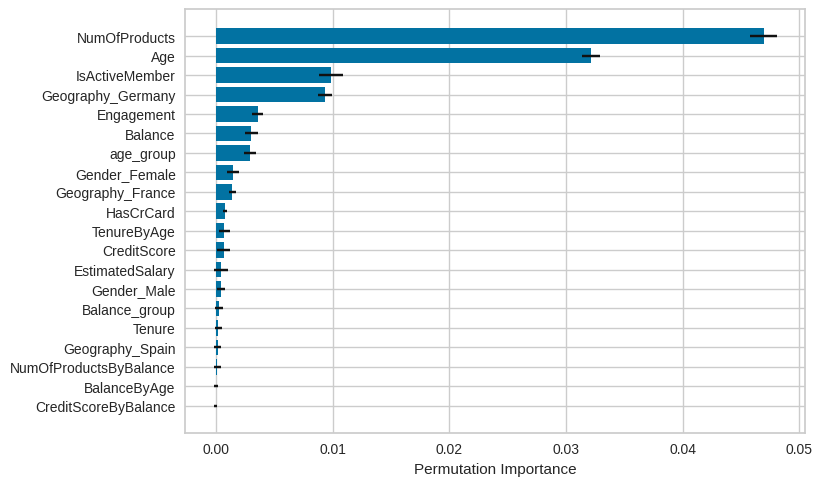

In [ ]:
feature_names = train_final_feature.columns

result = permutation_importance(clf_vc, X_valid, y_valid, n_repeats=10, random_state=42, n_jobs=-1)

# 결과 시각화
sorted_idx = result.importances_mean.argsort()
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], capsize=5)
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# 제출 파일 생성_voting_2
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_voting_2.csv',index=False)

## 보팅 3개(xgb,lgb,cat) - 0.8912

In [ ]:
# 보팅
clf_vc = VotingClassifier([('CAT', clf_cat), ('LGB', clf_lgb), ('XGB', clf_xgb)], voting='soft')

# 학습
clf_vc.fit(X_train, y_train)

# 검증 데이터 예측
y_valid_preds = clf_vc.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

# 검증 데이터 ROC AUC : 0.8925

In [ ]:
# 제출 파일 생성_voting_3
y_valid_preds = clf_vc.predict_proba(test)[:,1]
submission['Exited'] = y_valid_preds

submission.to_csv('submission_second_voting_3.csv',index=False)